## Job Search

#### John Stachurski


McCall style job search with persistent and transitory components to wages.

Wages at each point in time are given by

$$    w = \exp(z) + y $$

$$    y \sim \exp(μ + s ζ)  $$

$$    z' = d + ρ z + σ ε $$

with ζ and ε both iid and N(0, 1).   

The worker can either

* accept an offer and work permanently at that wage, or
* take unemployment compensation $c$ and wait till next period

The value function satisfies

$$ v(w, z) = \max \left\{ \frac{u(w)}{1-β}, u(c) + β \, \mathbb E_z v(w', z') \right\} $$

The continuation value function satisfies

$$    f^*(z) = u(c) + β \, \mathbb E_z \max \left\{ \frac{u(w')}{1-β}, f^*(z') \right\} $$


From $f^*$ we can solve the optimal stopping problem by stopping when

$$    \frac{u(w)}{1-β} \geq f(z) $$

For utility we take $u(c) = \ln(c)$.  The reservation wage is the wage where
equality holds in the last expression.

That is,

$$    w^*(z) = \exp(f^*(z) (1-β)) $$

Our aim is to solve for the reservation rule.  We do this by first computing
$f^*$ as the fixed point of the contraction map

$$    Qf(z) = u(c) + β \, \mathbb E_z \max \left\{ \frac{u(w')}{1-β}, f(z') \right\} $$

When we iterate, f is stored as a vector of values on a grid and these points
are interpolated into a function as necessary.

Interpolation is piecewise linear.

The integral in the definition of $Qf$ is calculated by Monte Carlo.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from lininterp import interp1d
from numba import jit, njit, prange

from quantecon import tic, toc

In [2]:
class JobSearch:

    def __init__(self,
                 μ=0.0, 
                 s=1.0, 
                 d=0.0, 
                 ρ=0.9, 
                 σ=0.1, 
                 β=0.98, 
                 c=5,
                 mc_size=2000,
                 grid_size=200):

        self.μ, self.s, self.d,  = μ, s, d, 
        self.ρ, self.σ, self.β, self.c = ρ, σ, β, c 

        # Set up grid
        z_mean = d / (1 - ρ)
        z_sd = np.sqrt(σ / (1 - ρ**2))
        k = 3  # std devs from mean
        a, b = z_mean - k * z_sd, z_mean + k * z_sd
        self.z_grid = np.linspace(a, b, grid_size)

        # Store shocks
        self.mc_size = mc_size
        self.e_draws = randn(2, mc_size)

    def pack_parameters(self):
        return self.μ, self.s, self.d, \
                self.ρ, self.σ, self.β, self.c
        
    def generate_Q_operator(self, parallel_flag=True):
        μ, s, d, ρ, σ, β, c = self.pack_parameters()
        e_draws = self.e_draws
        z_grid = self.z_grid
        M = e_draws.shape[1]

        @njit(parallel=parallel_flag)
        def Q(f_in, f_out):       
            for i in prange(len(z_grid)):
                z = z_grid[i]
                expectation = 0.0
                for m in range(M):
                    e1, e2 = e_draws[:, m]
                    z_next = d + ρ * z + σ * e1
                    go_val = interp1d(z_grid, f_in, z_next) # f(z') 
                    y_next = np.exp(μ + s * e2)             # y' draw
                    w_next = np.exp(z_next) + y_next        # w' draw
                    stop_val = np.log(w_next) / (1 - β)    
                    expectation += max(stop_val, go_val)
                expectation = expectation / M 
                f_out[i] = np.log(c) + β * expectation
        return Q

In [3]:
def compute_fixed_point(Q,
                        f_init,
                        tol=1e-4, 
                        max_iter=1000, 
                        verbose=True,
                        print_skip=25): 

    f_out = np.empty_like(f_init)

    # Set up loop
    f_in = f_init
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        Q(f_in, f_out)
        error = np.max(np.abs(f_in - f_out))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        f_in[:] = f_out

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return f_out

In [4]:
js = JobSearch()
Q = js.generate_Q_operator(parallel_flag=False)
Q_parallelized = js.generate_Q_operator(parallel_flag=True)

In [5]:
f_init = np.log(js.c) * np.ones(len(js.z_grid))
tic()
f_star = compute_fixed_point(Q, f_init, verbose=True)
toc()

Error at iteration 25 is 0.6526224066028021.
Error at iteration 50 is 0.14774795088432313.
Error at iteration 75 is 0.043032675555366495.
Error at iteration 100 is 0.013505076280281969.
Error at iteration 125 is 0.004347756099335243.
Error at iteration 150 is 0.0014135654134150855.
Error at iteration 175 is 0.00046113929521141017.
Error at iteration 200 is 0.00015055776538019927.

Converged in 210 iterations.
TOC: Elapsed: 0:00:38.11


'38.11'

In [6]:
f_init = np.log(js.c) * np.ones(len(js.z_grid))
tic()
f_star = compute_fixed_point(Q_parallelized, f_init, verbose=True)
toc()

Error at iteration 25 is 0.6526224066028021.
Error at iteration 50 is 0.14774795088432313.
Error at iteration 75 is 0.043032675555366495.
Error at iteration 100 is 0.013505076280281969.
Error at iteration 125 is 0.004347756099335243.
Error at iteration 150 is 0.0014135654134150855.
Error at iteration 175 is 0.00046113929521141017.
Error at iteration 200 is 0.00015055776538019927.

Converged in 210 iterations.
TOC: Elapsed: 0:00:6.65


'6.65'

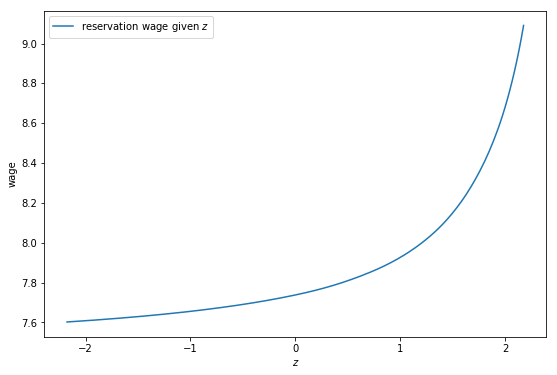

In [7]:
res_wage_function = np.exp(f_star * (1 - js.β))

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(js.z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

### Let's try changing unemployment compensation

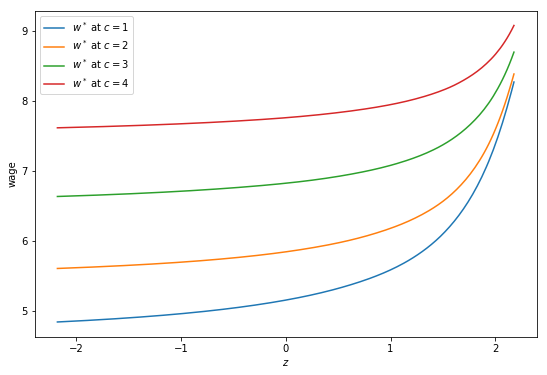

In [8]:
c_vals = 1, 2, 3, 4

fig, ax = plt.subplots(figsize=(9, 6))

for c in c_vals:
    js = JobSearch(c=c)
    Q = js.generate_Q_operator()
    f_star = compute_fixed_point(Q, f_init, verbose=False)
    res_wage_function = np.exp(f_star * (1 - js.β))
    ax.plot(js.z_grid, res_wage_function, label=f"$w^*$ at $c = {c}$")
    
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

### Exercise: Unemployment Duration

Let's study how mean unemployment duration varies with unemployment compensation.

In [9]:
def compute_unemployment_duration(js, seed=1234):
    
    Q = js.generate_Q_operator()
    f_star = compute_fixed_point(Q, f_init, verbose=False)
    μ, s, d, ρ, σ, β, c = js.pack_parameters()
    z_grid = js.z_grid
    np.random.seed(seed)
        
    @njit
    def f_star_function(z):
        return interp1d(z_grid, f_star, z)

    @njit
    def draw_tau(t_max=10_000):
        z = 0
        t = 0

        unemployed = True
        while unemployed and t < t_max:
            # draw current wage
            y = np.exp(μ + s * np.random.randn())
            w = np.exp(z) + y
            res_wage = np.exp(f_star_function(z) * (1 - β))
            # if optimal to stop, record t
            if w >= res_wage:
                unemployed = False
                τ = t
            # else increment data and state 
            else:
                z = ρ * z + d + σ * np.random.randn()
                t += 1
        return τ

    @njit(parallel=True)
    def compute_expected_tau(num_reps=100_000):
        sum_value = 0
        for i in prange(num_reps):
            sum_value += draw_tau()
        return sum_value / num_reps

    return compute_expected_tau()
        

In [10]:
c_vals = np.linspace(1.0, 10.0, 8)
durations = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    js = JobSearch(c=c)
    τ = compute_unemployment_duration(js)
    durations[i] = τ
    
    

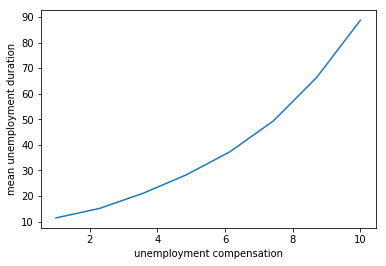

In [11]:
fig, ax = plt.subplots()
ax.plot(c_vals, durations)
ax.set_xlabel("unemployment compensation")
ax.set_ylabel("mean unemployment duration")
plt.show()